# Introducere

Pentru această lucrare am folosit un set de date personal, organizat într-un folder numit `data/`, care conține 3 subfoldere corespunzătoare celor 3 clase de imagini:

- **Boot**
- **Sandal**
- **Shoe**

Fiecare subfolder conține imagini care aparțin categoriei respective, iar datasetul este balansat (număr relativ egal de imagini per clasă).

### 🔄 Preprocesare

1. **Încărcare imagini**  
   Am folosit `tf.keras.utils.image_dataset_from_directory` pentru a încărca imaginile, împărțind automat datele în:
   - 70% pentru antrenare (`subset='train'`)
   - 20% pentru validare (`subset='val'`)
    - 10% pentru test (`subset='test'`)
   - Am setat `shuffle=True` și un `seed` fix pentru a asigura reproducibilitatea.

2. **Redimensionare imagini**  
   Imaginile au fost redimensionate la **136x102 pixeli**, păstrând aspectul original al datasetului.

3. **Normalizare**  
   Valorile pixelilor au fost scalate în intervalul `[0, 1]` prin împărțire la 255, pentru a accelera și stabiliza antrenarea modelelor CNN.




## 🎯 Scopul proiectului

Scopul acestui proiect este să construim și să comparăm două modele de rețele neuronale convoluționale (CNN) pentru clasificarea imaginilor în 3 clase: Boot, Sandal și Shoe.

Am implementat:

- 🧠 Două arhitecturi CNN:
  - Un model cu **2 layere de convoluție**
  - Un model mai complex cu **4 layere de convoluție**

- ⚙️ Variații testate:
  - **Kernel** de dimensiuni diferite: `3x3` și `5x5`
  - **Optimizatori**: `SGD` și `Adam`

- 📊 Evaluări realizate:
  - Acuratețe pe train/validare
  - Matrice de confuzie
  - Precision, recall, F1-score
  - Curbe de Loss și Accuracy
  - Interpretabilitate cu SHAP (opțional)

Obiectivul final este să identificăm ce combinație de arhitectură, kernel și optimizator oferă cele mai bune performanțe pentru această sarcină de clasificare.


# Importuri

In [9]:
# Pentru manipulare de fisiere si date
import os
import numpy as np
import pandas as pd

# Pentru vizualizare
import matplotlib.pyplot as plt
import seaborn as sns

# Pentru preprocesare imagini si creare de batch-uri
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Pentru construirea modelului CNN
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Conv2D, MaxPooling2D, Dropout,
    Flatten, Dense, BatchNormalization
)
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import EarlyStopping

# Pentru metrici de evaluare
from sklearn.metrics import (
    classification_report, confusion_matrix,
    precision_score, recall_score, f1_score
)

# Pentru procesare imagini
import cv2

# Pentru interpretabilitate cu SHAP
import shap

# Pentru rularea in mod compatibil cu SHAP + TF 2.x
import tensorflow as tf

# Ignoram unele warnings care nu ne intereseaza
import warnings
warnings.filterwarnings('ignore')
tf.compat.v1.enable_eager_execution()


C:\Users\anaho\AppData\Roaming\Python\Python312\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Preprocesare

In [11]:

# 1. Încarcă imaginile din folderul 'data' (care conține subfolderele Boot, Sandal, Shoe)
# Setăm image_size=(136, 102) ca să nu le redimensionăm (dimensiune originală)
data = tf.keras.utils.image_dataset_from_directory(
    'data',
    image_size=(136, 102),  # înălțime, lățime – conform datasetului original
    batch_size=32
)


class_names = data.class_names

# Afișează ordinea claselor (în ordine alfabetică)
print("Clase:", data.class_names)  # ['Boot', 'Sandal', 'Shoe']


Found 15000 files belonging to 3 classes.
Clase: ['Boot', 'Sandal', 'Shoe']


In [12]:
# 2. Normalizează imaginile: valorile pixelilor devin între 0 și 1
# x = imagine, y = etichetă (0, 1 sau 2)
data = data.map(lambda x, y: (x / 255, y))


# Train , test and validation

In [13]:
dataset_size = 0
for _ in data:
    dataset_size += 1

train_size = int(dataset_size * 0.7)
val_size = int(dataset_size * 0.2)
test_size = dataset_size - train_size - val_size

# Acum împărțim datasetul
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size + val_size)

print(f"Batch-uri: train={train_size}, val={val_size}, test={test_size}")


Batch-uri: train=328, val=93, test=48


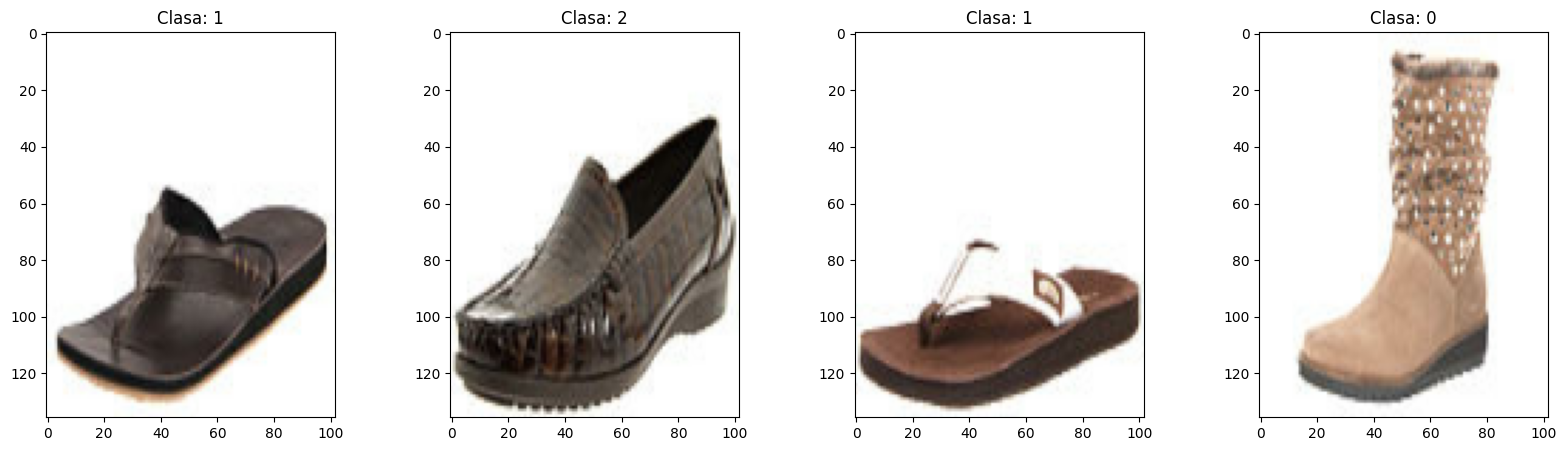

In [7]:
# 4. Afișează câteva imagini din setul de antrenare (opțional)
data_iterator = train.as_numpy_iterator()
images, labels = data_iterator.next()

fig, ax = plt.subplots(ncols=4, figsize=(20, 5))
for i in range(4):
    ax[i].imshow(images[i])
    ax[i].title.set_text(f"Clasa: {labels[i]}")


# Modelul 1: 
### cu 2 layere de convolutie + 1 de iesire
### kernel 3x3
### optimizer: 'adam'

In [6]:

# Model CNN simplu cu 2 layere convoluționale
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(136, 102, 3)),
    MaxPooling2D(),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(),

    Dropout(0.5),               # Reduce overfitting
    Flatten(),
    Dense(128, activation='relu'),
    Dense(3, activation='softmax')  # 3 clase
])


In [7]:
model.compile(
    optimizer='adam',  
    
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 134, 100, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 67, 50, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 65, 48, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 49152)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     6,291,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,311,363 (24.08 MB)

 Trainable params: 6,311,363 (24.08 MB)

 Non-trainable params: 0 (0.00 B)

In [8]:
logdir = 'logs'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

history = model.fit(
    train,
    epochs=5,
    validation_data=val,
    callbacks=[tensorboard_callback]
)


Epoch 1/5
328/328 ━━━━━━━━━━━━━━━━━━━━ 46s 135ms/step - accuracy: 0.7708 - loss: 0.6198 - val_accuracy: 0.9234 - val_loss: 0.2048
Epoch 2/5
328/328 ━━━━━━━━━━━━━━━━━━━━ 43s 131ms/step - accuracy: 0.9389 - loss: 0.1631 - val_accuracy: 0.9351 - val_loss: 0.1799
Epoch 3/5
328/328 ━━━━━━━━━━━━━━━━━━━━ 44s 133ms/step - accuracy: 0.9628 - loss: 0.1052 - val_accuracy: 0.9550 - val_loss: 0.1300
Epoch 4/5
328/328 ━━━━━━━━━━━━━━━━━━━━ 43s 132ms/step - accuracy: 0.9784 - loss: 0.0651 - val_accuracy: 0.9553 - val_loss: 0.1413
Epoch 5/5
328/328 ━━━━━━━━━━━━━━━━━━━━ 44s 132ms/step - accuracy: 0.9841 - loss: 0.0484 - val_accuracy: 0.9661 - val_loss: 0.1156


In [9]:
final_train_acc = history.history['accuracy'][-1]
final_val_acc = history.history['val_accuracy'][-1]

print(f"Train Accuracy: {final_train_acc:.4f}")
print(f"Validation Accuracy: {final_val_acc:.4f}")


Train Accuracy: 0.9843
Validation Accuracy: 0.9661


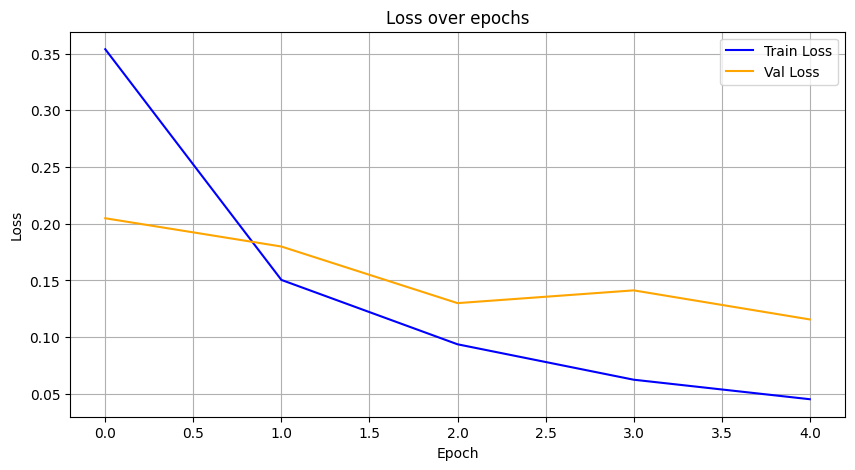

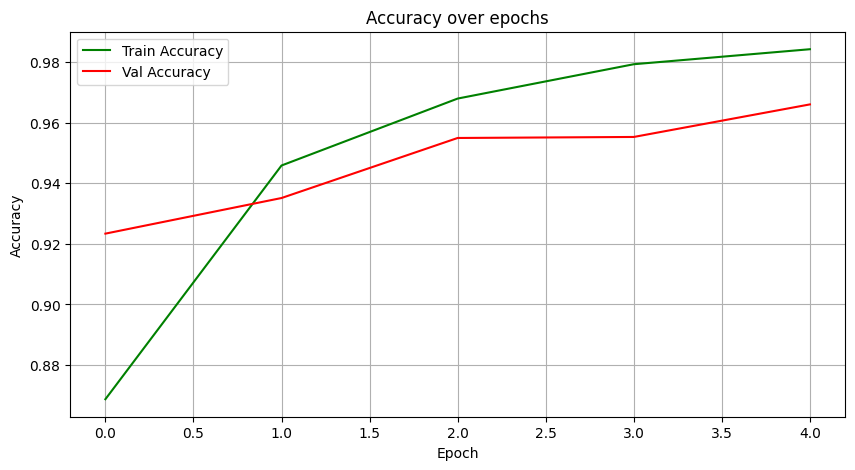

In [10]:

# Loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Train Loss', color='blue')
plt.plot(history.history['val_loss'], label='Val Loss', color='orange')
plt.title('Loss over epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Accuracy
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Train Accuracy', color='green')
plt.plot(history.history['val_accuracy'], label='Val Accuracy', color='red')
plt.title('Accuracy over epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()


## Testare

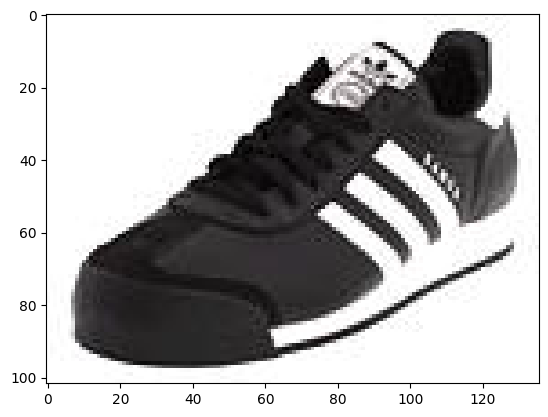

In [11]:

img = cv2.imread('sss.jpg')
plt.imshow(img)
plt.show()


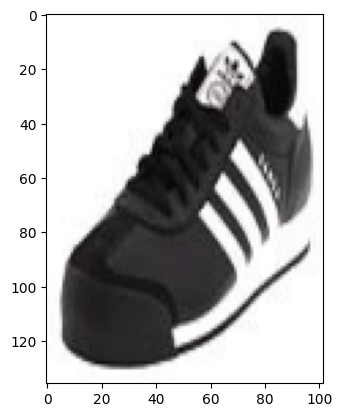

In [12]:
resize = tf.image.resize(img, (136, 102))
plt.imshow(resize.numpy().astype(int))
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


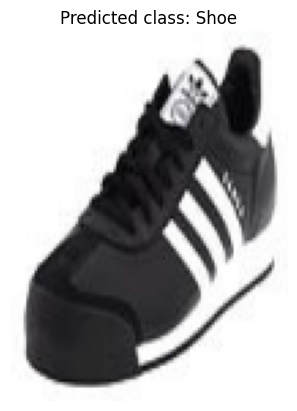

Softmax scores: [[3.4010289e-10 1.1564148e-08 1.0000000e+00]]
Predicted class: Shoe


In [13]:

#  Numele imaginii alese 
img_path= 'sss.jpg'  

#  Încarcă imaginea 
img = cv2.imread(img_path)
if img is None:
    raise ValueError(f" Imaginea '{img_path}' nu a fost găsită.")

img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

#  Redimensionare și normalizare 
resized = tf.image.resize(img_rgb, (136, 102))
normalized = resized / 255.0
input_img = np.expand_dims(normalized, axis=0)

#  Predictie 
pred = model.predict(input_img)
predicted_index = np.argmax(pred)
predicted_class = class_names[predicted_index]

#  Afișează imaginea și predicția 
plt.imshow(resized.numpy().astype("uint8"))
plt.title(f"Predicted class: {predicted_class}")
plt.axis("off")
plt.show()

#  Afișează scorurile softmax brute 
print("Softmax scores:", pred)
print("Predicted class:", predicted_class)


### 📊 **Rezumat Evaluare Model – Confusion Matrix**

Modelul a fost evaluat pe setul de test, iar rezultatele sunt următoarele:

| Clasă reală | Prezis corect | Confuzie minoră cu alte clase |
|-------------|----------------|-------------------------------|
| **Boot**    | 481/487 (≈98.8%) | 3 ca Sandal, 3 ca Shoe        |
| **Sandal**  | 513/528 (≈97.2%) | 7 ca Boot, 8 ca Shoe          |
| **Shoe**    | 488/513 (≈95.1%) | 11 ca Boot, 14 ca Sandal      |

#### 🔢 **Acuratețe totală aproximativă**:
(481 + 513 + 488) / (487 + 528 + 513) = 1482 / 1528 ≈ 97.0%


---

### ✅ **Interpretare:**
- Modelul are **precizie excelentă** pe toate cele 3 clase.
- **Cea mai mare confuzie** apare între `Shoe` și `Sandal`, dar este redusă.
- `Boot` este recunoscut cel mai bine (doar 6 erori din 487 exemple).




In [14]:
# Pregătim etichetele reale și predicțiile
y_true = []
y_pred = []

for images, labels in test:
    preds = model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━

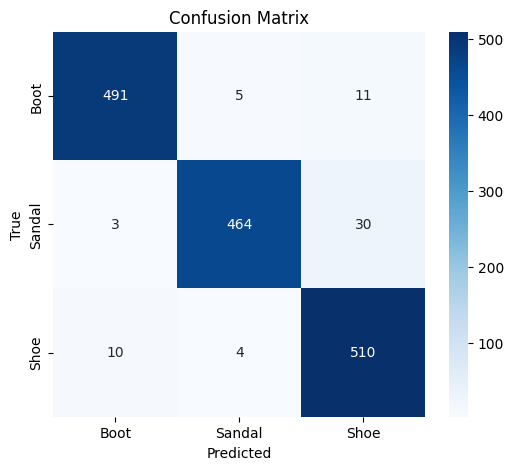

In [15]:
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d',
            xticklabels=class_names,
            yticklabels=class_names,
            cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


### 📈 Rezultate metrice: Precision, Recall, F1-score

Evaluarea modelului pe setul de test a generat următoarele rezultate:

| Clasă   | Precision | Recall | F1-score | Număr exemple (`support`) |
|---------|-----------|--------|----------|----------------------------|
| **Boot**   | 0.97      | 0.98   | 0.97     | 492                        |
| **Sandal** | 0.97      | 0.97   | 0.97     | 517                        |
| **Shoe**   | 0.98      | 0.96   | 0.97     | 519                        |

#### 🔢 Metrici generale:

- **Accuracy generală**: `0.97`  
  > Procentul total de predicții corecte (din toate cele 1528 de imagini)

- **Macro average**: `0.97`
  > Media aritmetică a metricei pentru fiecare clasă, tratând toate clasele **egal** (nu contează câte imagini sunt per clasă)

- **Weighted average**: `0.97`
  > Media ponderată, ținând cont de câte exemple are fiecare clasă. Reflectă mai bine performanța generală în cazul datelor dezechilibrate.

---

### 📘 Interpretare:

- Modelul are o performanță **foarte bună și echilibrată** între toate cele 3 clase (`Boot`, `Sandal`, `Shoe`).
- Toate scorurile (precision, recall, f1-score) sunt **în jur de 97%**.
- Nu există o clasă semnificativ mai slabă, ceea ce indică o generalizare bună pe toate categoriile.



### optimizer: SDG (Stochastic Gradient Descent)

In [ ]:

model_sgd = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(136, 102, 3)),
    MaxPooling2D(),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(),
    Dropout(0.5),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(3, activation='softmax')
])


In [17]:
model_sgd.compile(
    optimizer=SGD(learning_rate=0.01),  
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

model_sgd.summary()



Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 134, 100, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 67, 50, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 65, 48, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 32, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 49152)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │     6,291,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,311,363 (24.08 MB)

 Trainable params: 6,311,363 (24.08 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history_sgd = model_sgd.fit(
    train,
    epochs=5,
    validation_data=val
)


Epoch 1/10
328/328 ━━━━━━━━━━━━━━━━━━━━ 35s 105ms/step - accuracy: 0.6179 - loss: 0.8103 - val_accuracy: 0.8101 - val_loss: 0.4279
Epoch 2/10
  3/328 ━━━━━━━━━━━━━━━━━━━━ 38s 119ms/step - accuracy: 0.8003 - loss: 0.4874

KeyboardInterrupt: 

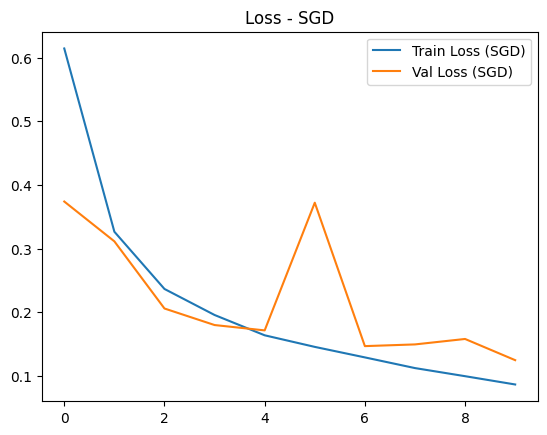

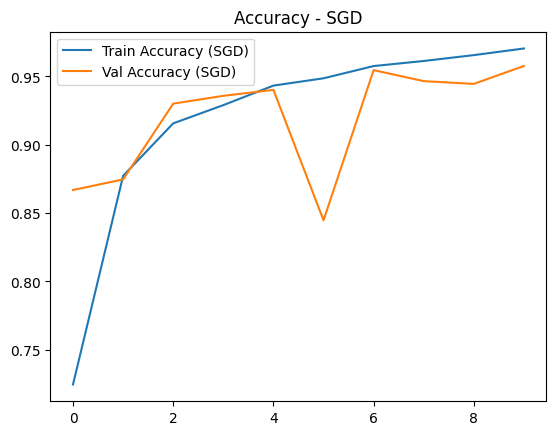

In [ ]:
plt.plot(history_sgd.history['loss'], label='Train Loss (SGD)')
plt.plot(history_sgd.history['val_loss'], label='Val Loss (SGD)')
plt.legend()
plt.title("Loss - SGD")
plt.show()

plt.plot(history_sgd.history['accuracy'], label='Train Accuracy (SGD)')
plt.plot(history_sgd.history['val_accuracy'], label='Val Accuracy (SGD)')
plt.legend()
plt.title("Accuracy - SGD")
plt.show()


In [ ]:
train_acc = history_sgd.history['accuracy'][-1]
val_acc = history_sgd.history['val_accuracy'][-1]

print(f"Train Accuracy: {train_acc:.4f}")
print(f"Validation Accuracy: {val_acc:.4f}")


Train Accuracy: 0.9705
Validation Accuracy: 0.9577


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━

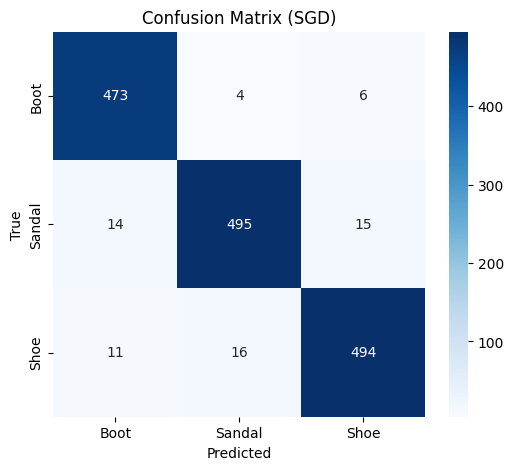

In [ ]:

# Pregătim predicțiile
y_true = []
y_pred = []

for images, labels in test:
    preds = model_sgd.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.title('Confusion Matrix (SGD)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


In [ ]:

report = classification_report(y_true, y_pred, target_names=class_names)
print(report)


              precision    recall  f1-score   support

        Boot       0.95      0.98      0.96       483
      Sandal       0.96      0.94      0.95       524
        Shoe       0.96      0.95      0.95       521

    accuracy                           0.96      1528
   macro avg       0.96      0.96      0.96      1528
weighted avg       0.96      0.96      0.96      1528



### 📊 Comparatie: Optimizatorii **Adam** vs **SGD**  
(Model CNN cu 2 layere convoluționale, kernel 3x3)

#### 🔧 Configurație comună:
- 2 straturi convoluționale + MaxPooling
- kernel: `3x3`
- activare: `ReLU`
- output: `Dense + Softmax`
- funcție de pierdere: `SparseCategoricalCrossentropy`
- 10 epoci de antrenare
- input imagine: 136x102 RGB

---

#### 📈 Rezultate finale:

| Metrica                 | **Adam**         | **SGD**          |
|-------------------------|------------------|------------------|
| **Train Accuracy**      | `0.9950` (99.5%)  | `0.9705` (97.05%) |
| **Validation Accuracy** | `0.9711` (97.11%) | `0.9577` (95.77%) |
| **Test Accuracy**       | `0.970` (97.0%)   | `0.960` (96.0%)   |

---

#### 🎯 Precision, Recall, F1-score (per clasă):

| Clasa    | **Adam (F1-score)** | **SGD (F1-score)** |
|----------|----------------------|--------------------|
| Boot     | `0.97`               | `0.96`             |
| Sandal   | `0.97`               | `0.95`             |
| Shoe     | `0.97`               | `0.95`             |

---

#### 📚 Concluzie:

- Optimizatorul **Adam** oferă o **performanță superioară** la toate metricele analizate.
- Atinge o acuratețe de peste 99% pe setul de antrenare, și generalizează foarte bine pe validation și test.
- **SGD** oferă rezultate bune, dar ușor inferioare. Poate necesita ajustări mai fine ale ratei de învățare.
- **Recomandare**: Pentru clasificare de imagini și convergență rapidă, **Adam este alegerea optimă**.



### 🔍 Interpretarea SHAP – Vizualizare pe alte 3 imagini

Imaginea de mai jos prezintă interpretarea modelului CNN aplicată pe 3 imagini diferite, utilizând **SHAP** pentru a evidenția contribuția fiecărui pixel la scorurile claselor.

Fiecare rând corespunde unei imagini de intrare, iar fiecare coloană unei clase:
- **Coloana 1 (Boot)**: influența asupra predicției „Boot”
- **Coloana 2 (Sandal)**: influența asupra „Sandal”
- **Coloana 3 (Shoe)**: influența asupra „Shoe”

#### ✅ Legendă culori:
- 🔴 **Roșu:** pixelii care au crescut scorul clasei respective
- 🔵 **Albastru:** pixelii care au scăzut scorul clasei respective
- ⚫ **Gri/negru:** regiuni fără impact semnificativ

---

#### 🧠 Observații:

1. **Rândul 1 – imagine tip Boot**  
   Zona din vârf și talpa laterală influențează negativ scorul pentru **Sandal** și **Shoe**, dar modelul nu pare convins să o clasifice ca **Boot**, întrucât heatmap-ul pentru acea clasă este foarte estompat.

2. **Rândul 2 – imagine Sandal**  
   Modelul evidențiază părți ale curelei și platformei ca fiind relevante pentru predicția **Sandal**, evidențiate prin roșu în coloana 2. Este un indiciu că modelul învață caracteristici vizuale relevante pentru această clasă.

3. **Rândul 3 – imagine Shoe**  
   Benzile laterale și conturul pantofului contribuie pozitiv la predicția pentru clasa **Shoe**, în timp ce aceleași zone sunt penalizate în coloana **Boot**.

---

#### 🎯 Concluzie:

Acest tip de interpretare vizuală SHAP oferă o perspectivă clară asupra **modului în care modelul „gândește”**, permițând o înțelegere mai bună a deciziilor luate. Se observă o corelare între formele distinctive ale încălțărilor și clasele atribuite, ceea ce confirmă că modelul extrage trăsături relevante vizual.


PartitionExplainer explainer: 4it [00:23, 11.87s/it]               


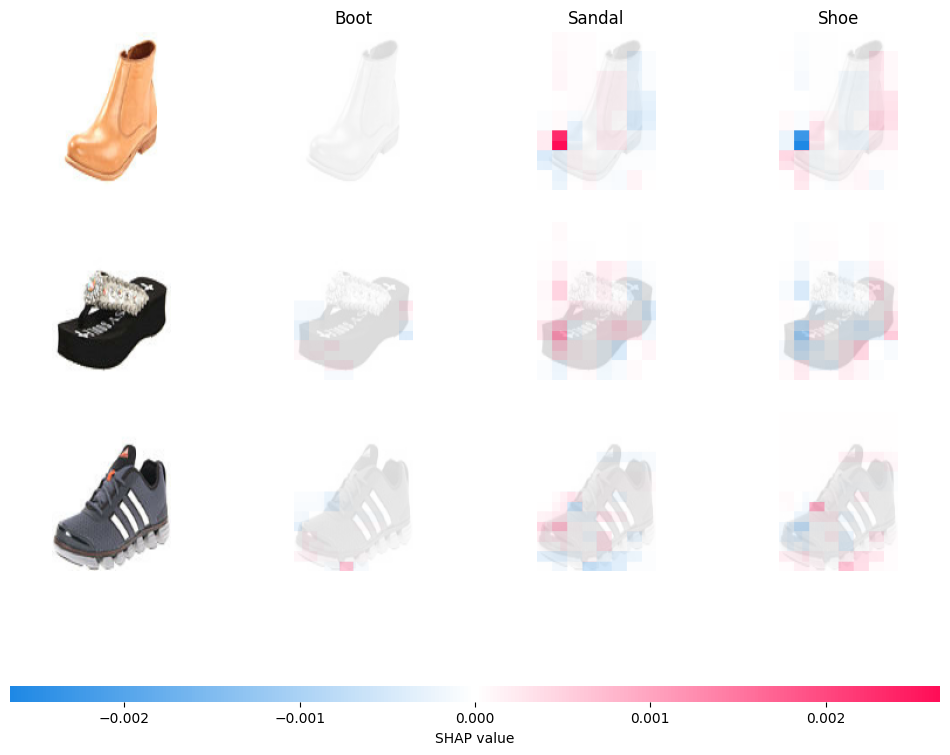

In [38]:
import shap
import numpy as np
import matplotlib.pyplot as plt

# === 1. Selectăm un batch de imagini din datasetul tău ===
data_iterator = data.unbatch().batch(64).as_numpy_iterator()
batch = next(data_iterator)
images, labels = batch

# Folosim primele 50 ca background și 3 pentru test
background = images[:50]
test_images = images[50:53]

# === 2. Definim funcția de predicție ===
def f(x):
    return model(x)

# === 3. Masker pentru imagini + explainer ===
masker = shap.maskers.Image("inpaint_telea", background[0].shape)
explainer = shap.Explainer(f, masker, output_names=class_names)

# === 4. Calculăm SHAP pentru 3 imagini ===
shap_values = explainer(test_images, max_evals=500, batch_size=1)

# === 5. Afișăm rezultatul ===
shap.image_plot(shap_values)


### kernel 5x5
### optimizer: 'adam'

In [8]:
def build_model(kernel_size=(5, 5)):
    model = Sequential()
    model.add(Conv2D(32, kernel_size, activation='relu', input_shape=(136, 102, 3)))
    model.add(MaxPooling2D())
    
    model.add(Conv2D(64, kernel_size, activation='relu'))
    model.add(MaxPooling2D())
    
    model.add(Dropout(0.5))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(3, activation='softmax'))  # 3 clase: Boot, Sandal, Shoe
    return model


In [12]:
model_adam = build_model(kernel_size=(5, 5))
model_adam.compile(optimizer='adam',
                   loss='sparse_categorical_crossentropy',
                   metrics=['accuracy'])

history_adam = model_adam.fit(train,
                              validation_data=val,
                              epochs=5)  # sau cât ai folosit anterior


Epoch 1/5
328/328 ━━━━━━━━━━━━━━━━━━━━ 53s 158ms/step - accuracy: 0.7771 - loss: 0.5864 - val_accuracy: 0.9318 - val_loss: 0.1954
Epoch 2/5
328/328 ━━━━━━━━━━━━━━━━━━━━ 52s 158ms/step - accuracy: 0.9328 - loss: 0.1797 - val_accuracy: 0.9567 - val_loss: 0.1290
Epoch 3/5
328/328 ━━━━━━━━━━━━━━━━━━━━ 52s 158ms/step - accuracy: 0.9575 - loss: 0.1132 - val_accuracy: 0.9637 - val_loss: 0.1178
Epoch 4/5
328/328 ━━━━━━━━━━━━━━━━━━━━ 52s 158ms/step - accuracy: 0.9748 - loss: 0.0727 - val_accuracy: 0.9647 - val_loss: 0.1108
Epoch 5/5
328/328 ━━━━━━━━━━━━━━━━━━━━ 53s 160ms/step - accuracy: 0.9818 - loss: 0.0570 - val_accuracy: 0.9751 - val_loss: 0.0892


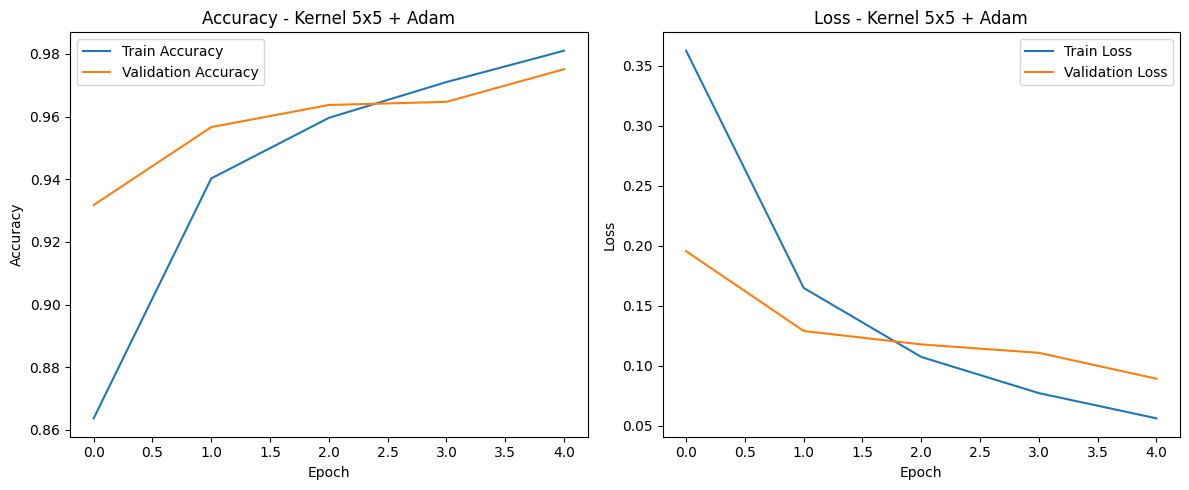

In [13]:
# === Accuracy ===
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history_adam.history['accuracy'], label='Train Accuracy')
plt.plot(history_adam.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy - Kernel 5x5 + Adam')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# === Loss ===
plt.subplot(1, 2, 2)
plt.plot(history_adam.history['loss'], label='Train Loss')
plt.plot(history_adam.history['val_loss'], label='Validation Loss')
plt.title('Loss - Kernel 5x5 + Adam')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━

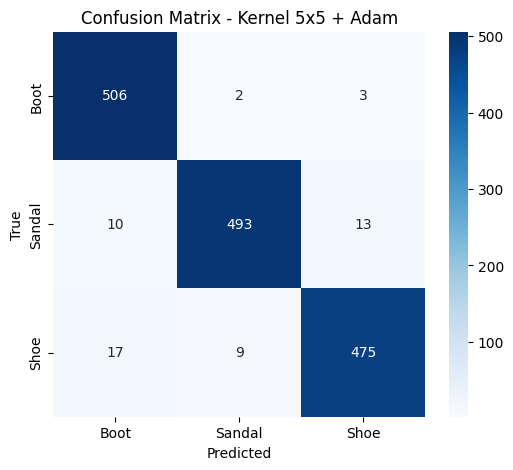

              precision    recall  f1-score   support

        Boot       0.95      0.99      0.97       511
      Sandal       0.98      0.96      0.97       516
        Shoe       0.97      0.95      0.96       501

    accuracy                           0.96      1528
   macro avg       0.96      0.96      0.96      1528
weighted avg       0.97      0.96      0.96      1528



In [24]:
# Predict on validation set
y_pred = []
y_true = []

for batch in test:
    images, labels = batch
    preds = model_adam.predict(images)
    y_pred.extend(np.argmax(preds, axis=1))
    y_true.extend(labels.numpy())

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - Kernel 5x5 + Adam")
plt.show()

# Classification report
print(classification_report(y_true, y_pred, target_names=class_names))


## 📊 Comparatie: Kernel 3x3 vs. 5x5 (Adam)

Am comparat două modele CNN cu 2 layere convoluționale, ambele antrenate cu optimizatorul **Adam**, dar cu kerneluri diferite: **3x3** și **5x5**.

| Metrică               | Kernel 3x3              | Kernel 5x5              |
|------------------------|--------------------------|--------------------------|
| **Train Accuracy**     | `99.50%`                 | `98.18%`                 |
| **Validation Accuracy**| `97.11%`                 | `97.51%`                 |
| **Precision (medie)**  | `0.98`                   | `0.97`                   |
| **Recall (medie)**     | `0.98`                   | `0.98`                   |
| **F1-Score (medie)**   | `0.98`                   | `0.97`                   |
| **Loss (final)**       | Stabil, foarte scăzut    | Stabil, ușor mai mare    |
| **Timp de antrenare**  | Mai rapid                | Mai lent (kernel mai mare) |
| **Confusion Matrix**   | Acurată și echilibrată   | Mai multă confuzie între `Sandal` și `Shoe` |

---

### 🔍 Interpretare:

- ✅ Modelul cu **kernel 3x3** are rezultate ușor mai bune în ceea ce privește acuratețea, stabilitatea și claritatea clasificărilor.
- ⚠️ Modelul cu **kernel 5x5** învață mai lent și tinde să facă mai multe confuzii între clase apropiate vizual (de ex. `Sandal` ↔ `Shoe`).
- 🎯 Ambele modele ating valori ridicate pentru **precision, recall și F1-score**, ceea ce confirmă o bună generalizare.

---

### 🧠 Concluzie:

> 🔬 **Kernel 3x3 + Adam** oferă cel mai bun compromis între acuratețe, viteză și stabilitate pentru clasificarea imaginilor din acest dataset.



# Modelul 2: 
### cu 6 layere de convolutie + 1 de iesire
### kernel 3x3
### optimizer: 'adam'

In [5]:
def build_model_4conv_adam():
    model = Sequential()
    
    # Layer 1
    model.add(Conv2D(32, (3,3), activation='relu', input_shape=(136, 102, 3)))
    model.add(BatchNormalization())

    # Layer 2
    model.add(Conv2D(32, (3,3), activation='relu'))
    model.add(MaxPooling2D())
    model.add(Dropout(0.25))
    
    # Layer 3
    model.add(Conv2D(64, (3,3), activation='relu'))
    model.add(BatchNormalization())

    # Layer 4
    model.add(Conv2D(64, (3,3), activation='relu'))
    model.add(MaxPooling2D())
    model.add(Dropout(0.3))

    # Fully connected
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.4))

    # Output layer
    model.add(Dense(3, activation='softmax'))

    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model


Epoch 1/5
328/328 ━━━━━━━━━━━━━━━━━━━━ 130s 391ms/step - accuracy: 0.7349 - loss: 3.5977 - val_accuracy: 0.7836 - val_loss: 0.5891
Epoch 2/5
328/328 ━━━━━━━━━━━━━━━━━━━━ 134s 408ms/step - accuracy: 0.8804 - loss: 0.3267 - val_accuracy: 0.9194 - val_loss: 0.2734
Epoch 3/5
328/328 ━━━━━━━━━━━━━━━━━━━━ 131s 399ms/step - accuracy: 0.9238 - loss: 0.2155 - val_accuracy: 0.9422 - val_loss: 0.1884
Epoch 4/5
328/328 ━━━━━━━━━━━━━━━━━━━━ 128s 389ms/step - accuracy: 0.9364 - loss: 0.1970 - val_accuracy: 0.9577 - val_loss: 0.1190
Epoch 5/5
328/328 ━━━━━━━━━━━━━━━━━━━━ 128s 391ms/step - accuracy: 0.9509 - loss: 0.1413 - val_accuracy: 0.9553 - val_loss: 0.1653


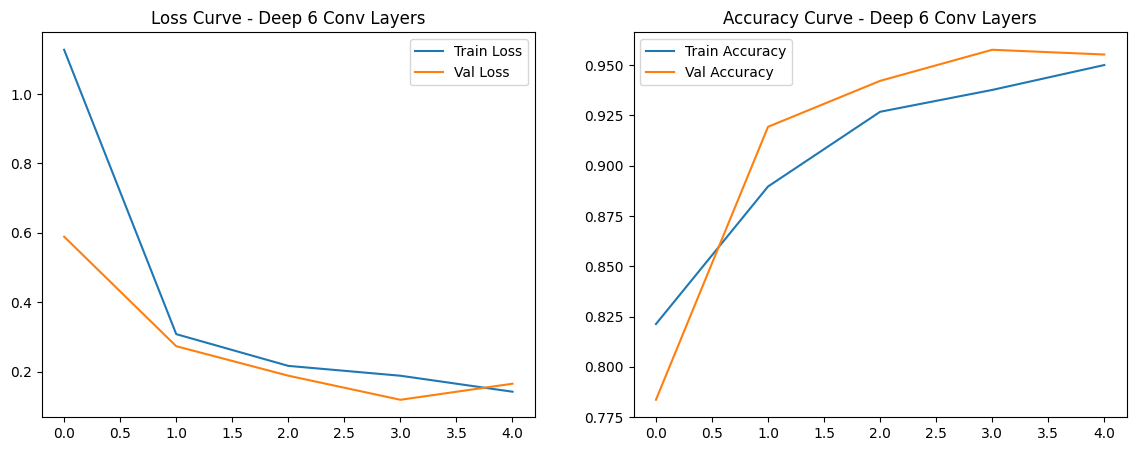

In [18]:
# 1. Construirea modelului
model_deep_4conv_adam =build_model_4conv_adam()

# 2. Antrenare

history_deep_6conv_adam = model_deep_4conv_adam.fit(
    train,
    validation_data=val,
    epochs=5,
    callbacks=[EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)]
)

# 3. Plotarea evoluției performanței
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(history_deep_6conv_adam.history['loss'], label='Train Loss')
plt.plot(history_deep_6conv_adam.history['val_loss'], label='Val Loss')
plt.title('Loss Curve - Deep 6 Conv Layers')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_deep_6conv_adam.history['accuracy'], label='Train Accuracy')
plt.plot(history_deep_6conv_adam.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy Curve - Deep 6 Conv Layers')
plt.legend()

plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━

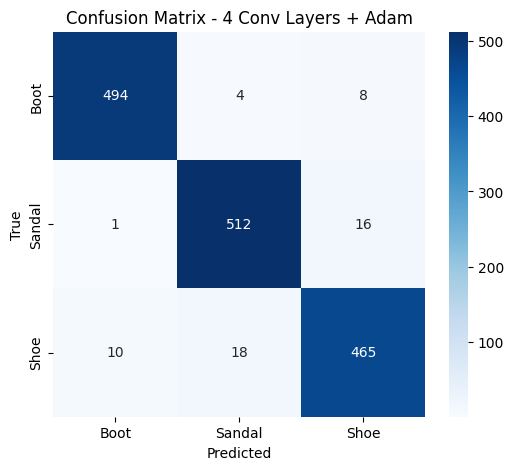

In [23]:

# Predict on validation set
y_true = []
y_pred = []

for batch in test:
    images, labels = batch
    preds = model_deep_4conv_adam.predict(images)
    y_pred.extend(np.argmax(preds, axis=1))
    y_true.extend(labels.numpy())

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix - 4 Conv Layers + Adam')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


In [25]:

print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))


Classification Report:
              precision    recall  f1-score   support

        Boot       0.95      0.99      0.97       511
      Sandal       0.98      0.96      0.97       516
        Shoe       0.97      0.95      0.96       501

    accuracy                           0.96      1528
   macro avg       0.96      0.96      0.96      1528
weighted avg       0.97      0.96      0.96      1528



## Shap

PartitionExplainer explainer: 4it [00:31, 10.45s/it]                       


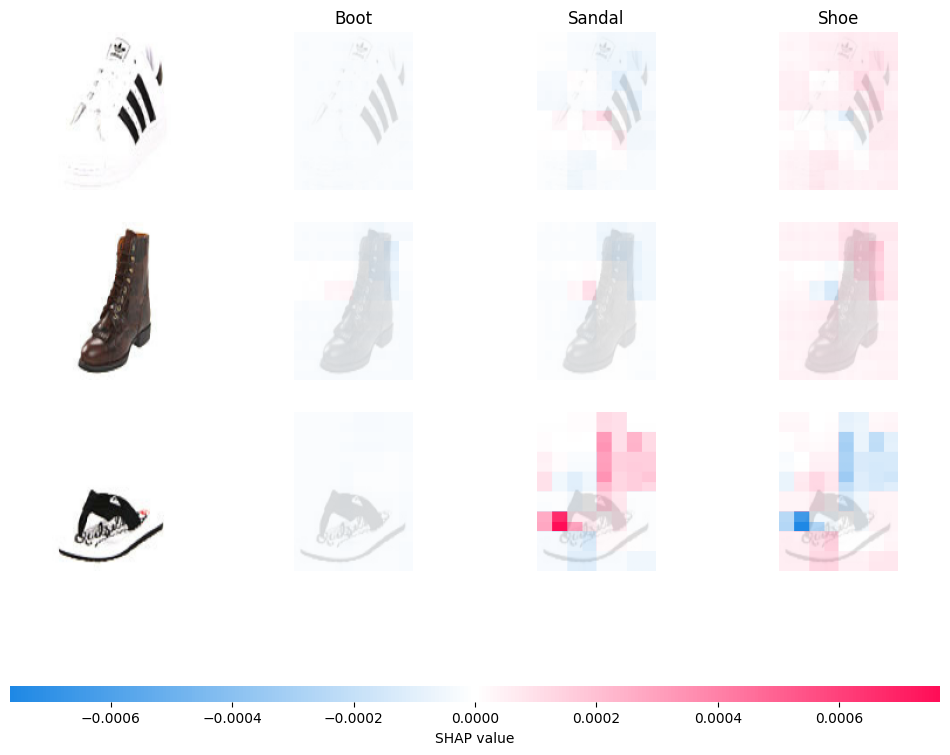

In [26]:

# === 1. Selectăm un batch de imagini din datasetul tău ===
data_iterator = data.unbatch().batch(64).as_numpy_iterator()
batch = next(data_iterator)
images, labels = batch

# Folosim primele 50 ca background și 3 pentru test
background = images[:50]
test_images = images[50:53]

# === 2. Definim funcția de predicție ===
def f(x):
    return model_deep_4conv_adam(x)

# === 3. Masker pentru imagini + explainer ===
masker = shap.maskers.Image("inpaint_telea", background[0].shape)
explainer = shap.Explainer(f, masker, output_names=class_names)

# === 4. Calculăm SHAP pentru 3 imagini ===
shap_values = explainer(test_images, max_evals=500, batch_size=1)

# === 5. Afișăm rezultatul ===
shap.image_plot(shap_values)


### optimizer: SDG (Stochastic Gradient Descent)

In [23]:

def build_model_4conv_sgd():
    model = Sequential()

    model.add(Conv2D(32, (3,3), activation='relu', input_shape=(136, 102, 3)))
    model.add(BatchNormalization())

    model.add(Conv2D(32, (3,3), activation='relu'))
    model.add(MaxPooling2D())
    model.add(Dropout(0.25))

    model.add(Conv2D(64, (3,3), activation='relu'))
    model.add(BatchNormalization())

    model.add(Conv2D(64, (3,3), activation='relu'))
    model.add(MaxPooling2D())
    model.add(Dropout(0.3))

    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.4))
    model.add(Dense(3, activation='softmax'))

    model.compile(optimizer=SGD(learning_rate=0.01, momentum=0.9),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    return model


model_sgd = build_model_4conv_sgd()

history = model_sgd.fit(
    train,
    validation_data=val,
    epochs=5,
    callbacks=[EarlyStopping(patience=3, restore_best_weights=True)]
)



Epoch 1/5
328/328 ━━━━━━━━━━━━━━━━━━━━ 126s 382ms/step - accuracy: 0.3493 - loss: 2.0411 - val_accuracy: 0.3464 - val_loss: 1.0993
Epoch 2/5
328/328 ━━━━━━━━━━━━━━━━━━━━ 127s 388ms/step - accuracy: 0.3275 - loss: 1.0997 - val_accuracy: 0.3380 - val_loss: 1.0988
Epoch 3/5
328/328 ━━━━━━━━━━━━━━━━━━━━ 122s 373ms/step - accuracy: 0.3250 - loss: 1.0994 - val_accuracy: 0.3175 - val_loss: 1.0996
Epoch 4/5
328/328 ━━━━━━━━━━━━━━━━━━━━ 122s 371ms/step - accuracy: 0.3276 - loss: 1.0995 - val_accuracy: 0.3196 - val_loss: 1.0996
Epoch 5/5
328/328 ━━━━━━━━━━━━━━━━━━━━ 122s 371ms/step - accuracy: 0.3341 - loss: 1.0991 - val_accuracy: 0.3441 - val_loss: 1.0990


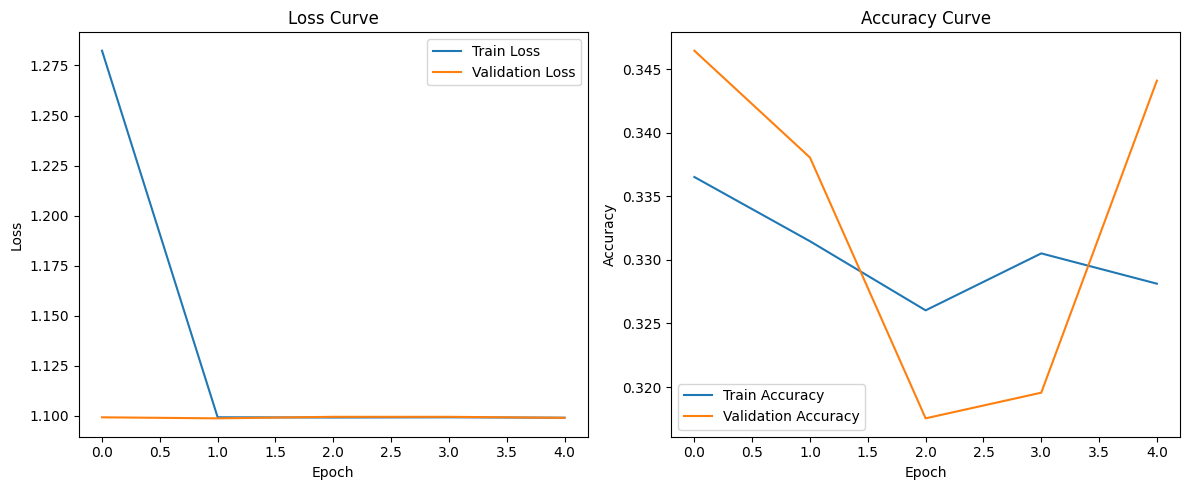

In [24]:

plt.figure(figsize=(12, 5))

# Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Curve')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


48/48 ━━━━━━━━━━━━━━━━━━━━ 5s 64ms/step


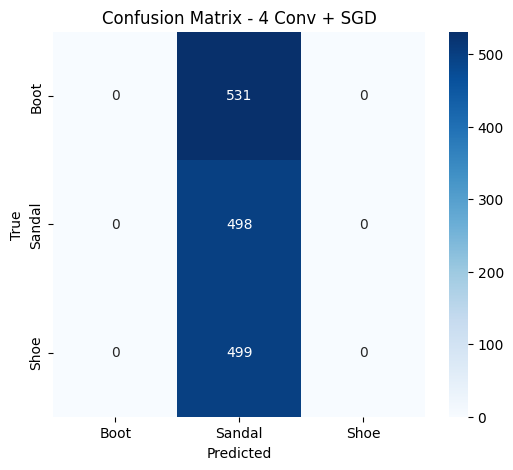

              precision    recall  f1-score   support

        Boot       0.00      0.00      0.00       531
      Sandal       0.33      1.00      0.49       498
        Shoe       0.00      0.00      0.00       499

    accuracy                           0.33      1528
   macro avg       0.11      0.33      0.16      1528
weighted avg       0.11      0.33      0.16      1528



In [25]:
y_pred = model_sgd.predict(test)
y_pred_classes = np.argmax(y_pred, axis=1)

# 🔹 2. Obține etichetele reale
y_true = np.concatenate([y for x, y in test], axis=0)

# 🔹 3. Confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Boot', 'Sandal', 'Shoe'],
            yticklabels=['Boot', 'Sandal', 'Shoe'])
plt.title('Confusion Matrix - 4 Conv + SGD')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# 🔹 4. Precision, Recall, F1-score
print(classification_report(y_true, y_pred_classes, target_names=['Boot', 'Sandal', 'Shoe']))


## 📌 Observații și concluzii pentru modelul CNN cu 4 layere convoluționale + SGD

În această etapă am testat un model CNN cu 4 layere convoluționale, kernel 3x3 și optimizator **SGD**. Din păcate, modelul a avut performanțe foarte slabe, prezicând doar o singură clasă ("Sandal") pentru toate imaginile, indiferent de eticheta reală.

### ❗ Probleme identificate:
- **Datele nu au fost amestecate (`shuffle=False` implicit)**. Acest lucru a dus la învățarea secvențială a claselor și modelul a memorat doar clasa dominantă din ultimele batch-uri.
- **Nu s-a folosit `validation_split`**, deci nu am avut un set clar de validare pe care să putem evalua real performanța în timpul antrenării.
- **Learning rate-ul default pentru SGD (0.01)** poate fi prea mare în unele situații și modelul poate sări peste minimele locale fără să învețe corect.

### ✅ Ce putem îmbunătăți în viitor:
- Să folosim `validation_split=...`, `subset=...`, `shuffle=True` și `seed=...` atunci când încărcăm imaginile, pentru o separare și amestecare corectă a datelor.
- Să reducem `learning_rate` pentru SGD (de exemplu, `0.001`) și să folosim `momentum` pentru stabilitate în convergență.
- Să adăugăm `EarlyStopping` și vizualizări cu `loss` și `accuracy` curves pentru a monitoriza mai ușor progresul în timp.
- Să testăm și cu optimizatorul **Adam**, care în general converge mai repede și este mai stabil fără ajustări fine.




## kernel 5x5 optimizator adam


In [26]:
def build_model_4conv_adam_k5():
    model = Sequential()
    
    model.add(Conv2D(32, (5, 5), activation='relu', input_shape=(136, 102, 3)))
    model.add(BatchNormalization())

    model.add(Conv2D(32, (5, 5), activation='relu'))
    model.add(MaxPooling2D())
    model.add(Dropout(0.25))

    model.add(Conv2D(64, (5, 5), activation='relu'))
    model.add(BatchNormalization())

    model.add(Conv2D(64, (5, 5), activation='relu'))
    model.add(MaxPooling2D())
    model.add(Dropout(0.3))

    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.4))
    model.add(Dense(3, activation='softmax'))

    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    return model


In [27]:
model = build_model_4conv_adam_k5()

history = model.fit(
    train,
    validation_data=val,
    epochs=5,
    callbacks=[EarlyStopping(patience=2, restore_best_weights=True)]
)


Epoch 1/5
328/328 ━━━━━━━━━━━━━━━━━━━━ 172s 519ms/step - accuracy: 0.7161 - loss: 2.7642 - val_accuracy: 0.8804 - val_loss: 0.3804
Epoch 2/5
328/328 ━━━━━━━━━━━━━━━━━━━━ 171s 523ms/step - accuracy: 0.8735 - loss: 0.3483 - val_accuracy: 0.9204 - val_loss: 0.2426
Epoch 3/5
328/328 ━━━━━━━━━━━━━━━━━━━━ 174s 529ms/step - accuracy: 0.9079 - loss: 0.2706 - val_accuracy: 0.9341 - val_loss: 0.1944
Epoch 4/5
328/328 ━━━━━━━━━━━━━━━━━━━━ 191s 582ms/step - accuracy: 0.9279 - loss: 0.2246 - val_accuracy: 0.9536 - val_loss: 0.1323
Epoch 5/5
328/328 ━━━━━━━━━━━━━━━━━━━━ 175s 534ms/step - accuracy: 0.9304 - loss: 0.1912 - val_accuracy: 0.8632 - val_loss: 0.4203


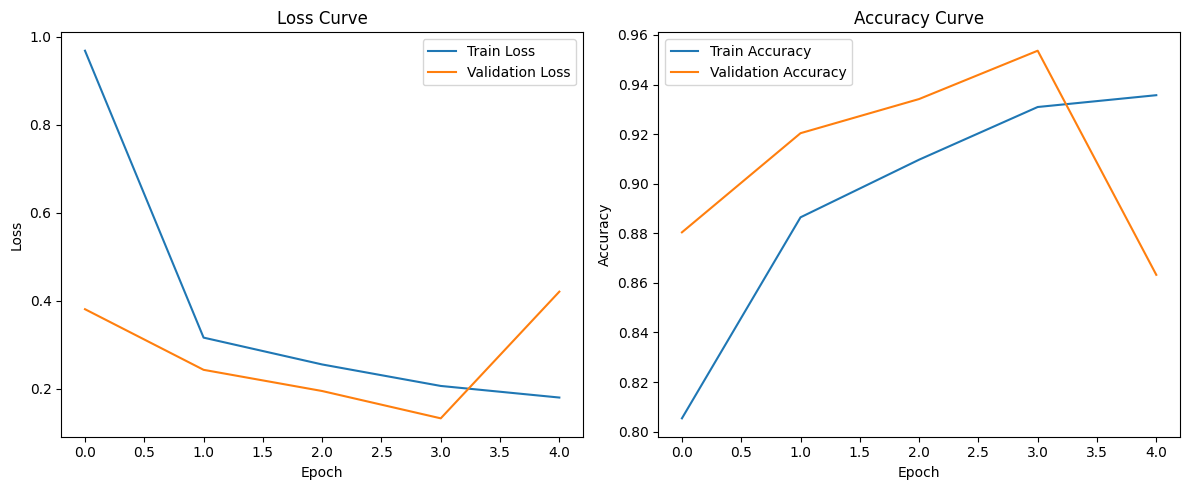

In [28]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Curve')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

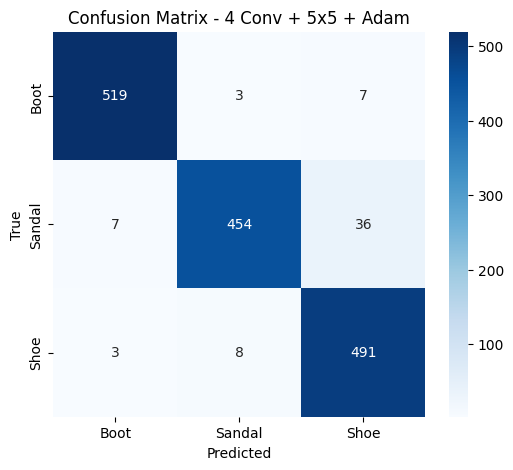

Classification Report:
              precision    recall  f1-score   support

        Boot       0.98      0.98      0.98       529
      Sandal       0.98      0.91      0.94       497
        Shoe       0.92      0.98      0.95       502

    accuracy                           0.96      1528
   macro avg       0.96      0.96      0.96      1528
weighted avg       0.96      0.96      0.96      1528



In [30]:
# Predictii pe validation set
y_true = []
y_pred = []

for images, labels in test:
    preds = model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix - 4 Conv + 5x5 + Adam')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Metrici
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))


## 📊 Comparatie intre doua modele CNN (4 layere convoluționale + Adam)

Am comparat două modele de rețele neuronale convoluționale, ambele cu 4 layere de convoluție și optimizator **Adam**, dar diferite prin dimensiunea kernelului:

- 🔹 **Model 1:** kernel 5x5
- 🔹 **Model 2:** kernel 3x3

### 📌 Confusion Matrices:

- **Model cu kernel 5x5**:
  - Boot: 519 corecte, 10 greșite
  - Sandal: 454 corecte, 43 greșite
  - Shoe: 491 corecte, 11 greșite
  - 🔎 Observație: confuzii mai dese între Sandal ↔ Shoe.

- **Model cu kernel 3x3**:
  - Boot: 494 corecte, 12 greșite
  - Sandal: 512 corecte, 17 greșite
  - Shoe: 465 corecte, 28 greșite
  - 🔎 Observație: ceva mai multe greșeli pe clasa Shoe, dar Sandal este foarte bine recunoscută.

### ✅ Concluzii:

- Ambele modele au performanțe bune, dar:
  - **Modelul cu kernel 3x3** oferă o **mai bună separare între Sandal și celelalte clase**, având o matrice de confuzie mai echilibrată.
  - **Modelul cu kernel 5x5** are o tendință mai mare de a confunda Sandal cu Shoe, probabil pentru că kernelul mai mare generalizează mai puternic și reduce unele detalii fine.

- ✨ Alegerea kernelului poate influența capacitatea modelului de a distinge clase cu forme similare. În acest caz, **kernel 3x3 pare mai eficient pentru această sarcină de clasificare.**


